# 0. Imports & Seeding

In this section, we import all the essential libraries used throughout the notebook:

- **NumPy & Pandas** for numerical and tabular data handling  
- **Scikit-learn** for preprocessing and splitting data  
- **Matplotlib** for visualizations  
- **TensorFlow / Keras** for implementing the DragonNet model  
- **RandomForestRegressor** for the baseline T-Learner  
- **Training utilities** like `EarlyStopping` and `ReduceLROnPlateau`  
- **Warnings suppressed** to keep the notebook clean  
- **Random seeds fixed** to ensure reproducibility across runs


In [14]:
# ============================================================
# 0. IMPORTS & SEEDING
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Concatenate, Dropout, BatchNormalization, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)


# 1. Load Data

In this step, we load the dataset from the specified CSV file.  
We also define the names of the **outcome column** (`conversion`) and the **treatment column** (`treatment`).

After loading, we print:
- the shape of the dataset
- the first few rows to verify the structure

Ensure that the path `sampled_1M.csv` is correct for your environment.


In [15]:
# ============================================================
# 1. LOAD DATA
# ============================================================
CSV_PATH = "sampled_1M.csv"
OUTCOME_COL = "conversion"   # 0/1
TREATMENT_COL = "treatment"  # 0/1

df = pd.read_csv(CSV_PATH)
print("Raw shape:", df.shape)
print(df.head())


Raw shape: (1000000, 16)
          f0         f1        f2        f3         f4        f5        f6  \
0  21.540788  10.059654  8.214383  4.679882  10.280525  4.115453 -4.595460   
1  16.817444  10.059654  8.727821  3.907662  10.280525  4.115453 -5.987667   
2  13.882037  10.059654  8.214383  3.907662  10.280525  4.115453 -1.288207   
3  22.992071  10.059654  8.214383  4.679882  10.280525  4.115453 -1.288207   
4  22.390426  10.059654  8.214383  4.679882  10.280525  4.115453 -2.411115   

         f7        f8         f9       f10       f11  treatment  conversion  \
0  4.833815  3.971858  13.190056  5.300375 -0.168679          0           0   
1  4.833815  3.863287  13.190056  5.300375 -0.168679          0           0   
2  4.833815  3.971858  13.190056  5.300375 -0.168679          0           0   
3  4.833815  3.971858  13.190056  5.300375 -0.168679          0           0   
4  4.833815  3.971858  13.190056  5.300375 -0.168679          0           0   

   visit  exposure  
0      0  

# 2. Preprocessing

In this section, we prepare the dataset for modeling:

### Steps performed:
1. **Separate labels**  
   - `y` = outcome (`conversion`)  
   - `t` = treatment indicator  

2. **Extract features**  
   We drop the outcome and treatment columns to obtain `X`.

3. **Train / Validation / Test split**  
   - 70% training  
   - 15% validation  
   - 15% testing  
   Stratification is done on the treatment variable to maintain the treated/control ratio.

4. **Standardization**  
   We apply `StandardScaler` to normalize all features.  
   Scaling is fit on the training data and applied to val/test splits.

Finally, we print the shapes to verify the splits.


In [16]:
# ============================================================
# 2. PREPROCESSING
# ============================================================

# Separate outcome and treatment
y = df[OUTCOME_COL].values.astype("float32")
t = df[TREATMENT_COL].values.astype("float32")

# Features (drop outcome + treatment)
X = df.drop(columns=[OUTCOME_COL, TREATMENT_COL]).values.astype("float32")

# Train / Val / Test split
X_train, X_temp, y_train, y_temp, t_train, t_temp = train_test_split(
    X, y, t, test_size=0.3, random_state=42, stratify=t
)
X_val, X_test, y_val, y_test, t_val, t_test = train_test_split(
    X_temp, y_temp, t_temp, test_size=0.5, random_state=42, stratify=t_temp
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

# Standardize numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

Train: (700000, 14)
Val:   (150000, 14)
Test:  (150000, 14)


# 3. DragonNet Losses & Custom Layers

This section implements the core loss functions and components required for DragonNet training.

### Components included:

### **1. Regression Loss**
Measures the factual outcome prediction error for:
- `y0_pred` when `t=0`
- `y1_pred` when `t=1`

### **2. Binary Classification Loss**
Cross-entropy loss used for propensity score (`t_pred`) estimation.  
A small numerical adjustment is added to avoid instability in `log(0)`.

### **3. Vanilla DragonNet Loss**
Simply the sum of regression loss + treatment prediction loss.

### **4. StableEpsilonLayer**
A custom Keras layer that adds a trainable scalar `ε` (epsilon),  
used during targeted regularization to stabilize counterfactual predictions.

### **5. TARReg (Targeted Regularization) Loss**
This adds targeted regularization on top of the vanilla loss:
- Computes clever covariate *h*
- Perturbs outcome predictions using epsilon
- Penalizes the discrepancy between perturbed and true outcomes

This improves identifiability and reduces bias in treatment effect estimation.


In [17]:
# ============================================================
# 3. DRAGONNET LOSSES & LAYERS
# ============================================================

def regression_loss(concat_true, concat_pred):
    y_true = concat_true[:, 0]
    t_true = concat_true[:, 1]
    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]
    return tf.reduce_sum((1 - t_true) * tf.square(y_true - y0_pred) +
                         t_true       * tf.square(y_true - y1_pred))

def binary_classification_loss(concat_true, concat_pred):
    t_true = concat_true[:, 1]
    t_pred = concat_pred[:, 2]
    t_pred = (t_pred + 1e-3) / 1.002  # avoid log(0)
    return tf.reduce_sum(tf.keras.losses.binary_crossentropy(t_true, t_pred))

def dragonnet_vanilla_loss(concat_true, concat_pred):
    return regression_loss(concat_true, concat_pred) + \
           binary_classification_loss(concat_true, concat_pred)

class StableEpsilonLayer(Layer):
    def build(self, input_shape):
        self.epsilon = self.add_weight(
            shape=(1, 1),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        eps = tf.clip_by_value(self.epsilon, -0.1, 0.1)
        return eps * tf.ones_like(inputs)[:, :1]

def make_tarreg_loss(ratio=1.0):
    def tarreg_loss(concat_true, concat_pred):
        base_loss = dragonnet_vanilla_loss(concat_true, concat_pred)

        y_true = concat_true[:, 0]
        t_true = concat_true[:, 1]

        y0_pred = concat_pred[:, 0]
        y1_pred = concat_pred[:, 1]
        t_pred  = concat_pred[:, 2]
        eps     = concat_pred[:, 3]

        # stabilize propensity predictions
        t_pred = (t_pred + 0.01) / 1.02

        # factual prediction
        y_pred = t_true * y1_pred + (1 - t_true) * y0_pred

        # clever covariate
        h = t_true / t_pred - (1 - t_true) / (1 - t_pred)

        y_pert = y_pred + eps * h
        targeted_reg = tf.reduce_sum(tf.square(y_true - y_pert))

        return base_loss + ratio * targeted_reg
    return tarreg_loss


# 4. Optimized DragonNet Model

This section defines the full architecture used for the **Hard Problem**:  
an optimized version of the DragonNet model.

### Key components included:

### **1. Dense Block (with optional Residual Connection)**
A reusable block that performs:
- Dense layer with L2 regularization  
- Batch Normalization  
- GELU activation  
- Dropout  
- Residual skip connection (only if dimensions match)

This improves stability and helps deeper representations train better.

### **2. Shared Representation Network**
Three stacked dense blocks extract a common feature representation  
used by all three model heads:  
- treatment prediction  
- Y(0) prediction  
- Y(1) prediction  

### **3. Propensity Head (`t_pred`)**
A small feed-forward network predicting the treatment probability.  
Uses **sigmoid** activation.

### **4. Outcome Heads (`y0_pred`, `y1_pred`)**
Two parallel networks predicting potential outcomes under:
- control (0)  
- treatment (1)

### **5. Epsilon Layer (`eps`)**
A trainable scalar used in targeted regularization.

### **6. Final Model Output**
A concatenated output:  
```
[y0_pred, y1_pred, t_pred, eps]
```

This structure is required for the TARReg loss defined earlier.


In [18]:
# ============================================================
# 4. OPTIMIZED DRAGONNET MODEL
# ============================================================

def dense_block(x, units, reg_l2, dropout):
    skip = x
    x = Dense(units,
              kernel_regularizer=regularizers.l2(reg_l2),
              kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.gelu(x)
    x = Dropout(dropout)(x)
    if int(skip.shape[-1]) == units:
        x = x + skip
    return x

def build_dragonnet_optimized(input_dim, reg_l2=1e-4, dropout=0.15, hidden=256):
    inputs = Input(shape=(input_dim,), name="input")

    # Shared representation
    x = dense_block(inputs,   hidden,   reg_l2, dropout)
    x = dense_block(x,        hidden,   reg_l2, dropout)
    x = dense_block(x,        hidden//2,reg_l2, dropout)
    shared_repr = x

    # Propensity head
    t_head = Dense(hidden//2, activation="gelu")(shared_repr)
    t_head = Dense(hidden//4, activation="gelu")(t_head)
    t_pred = Dense(1, activation="sigmoid", name="t_pred")(t_head)

    # Outcome Y(0)
    y0 = Dense(hidden//2, activation="gelu")(shared_repr)
    y0 = Dense(hidden//4, activation="gelu")(y0)
    y0_pred = Dense(1, name="y0_pred")(y0)

    # Outcome Y(1)
    y1 = Dense(hidden//2, activation="gelu")(shared_repr)
    y1 = Dense(hidden//4, activation="gelu")(y1)
    y1_pred = Dense(1, name="y1_pred")(y1)

    # Epsilon
    eps_layer = StableEpsilonLayer(name="eps")
    eps = eps_layer(t_pred)

    concat_pred = Concatenate(axis=1)([y0_pred, y1_pred, t_pred, eps])
    model = Model(inputs=inputs, outputs=concat_pred, name="DragonNetOptimized")
    return model


# 5. Training the Optimized DragonNet

This function encapsulates the full training pipeline for the optimized DragonNet model.

### **Key steps in the training process:**

### 1. **Model Construction**
The model architecture is created using the previously defined  
`build_dragonnet_optimized()` function.

### 2. **Label Preparation**
DragonNet requires a combined label matrix:
- Column 0 → factual outcome `y`
- Column 1 → treatment indicator `t`

So we stack them into:
```
[y, t]
```

### 3. **Optimizer Setup**
We use:
- **Adam optimizer**
- Gradient clipping (`clipnorm=1.0`) for stability

### 4. **Loss Function**
The model is trained using:
- **TARReg loss** (targeted regularization)
- Controlled by `tarreg_ratio`

### 5. **Callbacks**
To ensure efficient and stable training:
- **EarlyStopping**  
  Stops training if validation loss stops improving.
- **ReduceLROnPlateau**  
  Reduces learning rate when progress stalls.

### 6. **Model Fitting**
Training runs for a maximum of `epochs`, using the specified `batch_size`.

The function returns the trained model instance.


In [19]:
# ============================================================
# 5. TRAINING DRAGONNET
# ============================================================

def train_dragonnet_optimized(
        X_train, y_train, t_train,
        X_val, y_val, t_val,
        lr=1e-3, batch_size=4096,
        epochs=50, tarreg_ratio=1.0,
        reg_l2=1e-4, dropout=0.15):

    input_dim = X_train.shape[1]
    model = build_dragonnet_optimized(input_dim, reg_l2=reg_l2, dropout=dropout)

    y_train_c = np.stack([y_train, t_train], axis=1)
    y_val_c   = np.stack([y_val,   t_val],   axis=1)

    optimizer = Adam(learning_rate=lr, clipnorm=1.0)

    model.compile(
        optimizer=optimizer,
        loss=make_tarreg_loss(tarreg_ratio),
        metrics=[]
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4,
                          min_lr=1e-5, verbose=1)
    ]

    model.fit(
        X_train, y_train_c,
        validation_data=(X_val, y_val_c),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=2
    )
    return model


# 6. Uplift Metrics (AUUC & Qini)

This section defines the evaluation metrics used for uplift modeling.  
We compute two key curves:

---

## **1. AUUC — Area Under the Uplift Curve**
Steps:
- Sort samples by predicted uplift (descending)
- Compute cumulative treatment and control outcomes
- Uplift curve = cumulative treated outcome − cumulative control outcome
- AUUC = area under this uplift curve

Higher AUUC means better ranking of users by true uplift.

---

## **2. Qini Curve and Qini Coefficient**
The Qini curve measures incremental gains relative to a baseline random model.

Computation:
- Again sort by predicted uplift  
- Use adjusted cumulative differences between treated and control groups  
- Qini = area under the Qini curve

---

## **3. Model Evaluation Function**
`evaluate_dragonnet()`:
- Predicts outcomes using the model  
- Computes uplift = Y(1) − Y(0)  
- Computes AUUC & Qini  
- Plots both curves  
- Returns the values and the uplift vector

This section gives complete diagnostics for uplift performance.


In [20]:
# ============================================================
# 6. UPLIFT METRICS (AUUC & QINI)
# ============================================================

def _sort(y, t, uplift):
    idx = np.argsort(-uplift)
    return y[idx], t[idx]

def compute_auuc(y, t, uplift):
    y_s, t_s = _sort(y, t, uplift)
    n = len(y_s)
    cum_t = np.cumsum(y_s * t_s)
    cum_c = np.cumsum(y_s * (1 - t_s))
    uplift_curve = cum_t - cum_c
    prop = np.arange(1, n+1) / n
    auuc = np.trapz(uplift_curve, prop)
    return auuc, prop, uplift_curve

def compute_qini(y, t, uplift):
    y_s, t_s = _sort(y, t, uplift)
    n = len(y_s)
    cum_y_t = np.cumsum(y_s * t_s)
    cum_y_c = np.cumsum(y_s * (1 - t_s))
    qini_curve = cum_y_t - cum_y_c * (cum_y_t / np.maximum(1, np.cumsum(t_s)))
    prop = np.arange(1, n+1) / n
    qini = np.trapz(qini_curve, prop)
    return qini, prop, qini_curve

def evaluate_dragonnet(model, X, y, t, label="DragonNetOptimized"):
    preds = model.predict(X, batch_size=4096, verbose=0)
    uplift = preds[:, 1] - preds[:, 0]

    auuc, prop_u, curve_u = compute_auuc(y, t, uplift)
    qini, prop_q, curve_q = compute_qini(y, t, uplift)

    print(f"{label} AUUC: {auuc:.4f}")
    print(f"{label} Qini: {qini:.4f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(prop_u, curve_u)
    plt.axhline(0, color='k', linestyle='--', label='Baseline')
    plt.title(f"{label} Uplift Curve (AUUC={auuc:.4f})")
    plt.xlabel("Proportion of population")
    plt.ylabel("Cumulative uplift")

    plt.subplot(1,2,2)
    plt.plot(prop_q, curve_q)
    plt.axhline(0, color='k', linestyle='--', label='Baseline')
    plt.title(f"{label} Qini Curve (Qini={qini:.2f})")
    plt.xlabel("Proportion of population")
    plt.ylabel("Qini")

    plt.tight_layout()
    plt.show()

    return auuc, qini, uplift


# 7. Easy Baseline — Two-Model T-Learner

This section implements the **easy baseline model** for uplift modeling:  
a **T-Learner** using two separate Random Forest regressors.

---

## **How the T-Learner works**

### **1. Split by Treatment Group**
- Train one model only on **treated** samples → predicts `Y(1)`
- Train another model only on **control** samples → predicts `Y(0)`

### **2. Predict Uplift**
For any sample `x`:
```
uplift(x) = y1_pred(x) − y0_pred(x)
```

### **3. Evaluation**
We reuse the previously defined AUUC and Qini metrics to evaluate the baseline.  
The function:
- Computes uplift scores  
- Plots AUUC and Qini curves  
- Prints final metrics  

This provides a benchmark against which the optimized DragonNet (hard problem) can be compared.


In [21]:
# ============================================================
# 7. EASY BASELINE — TWO-MODEL T-LEARNER
# ============================================================

def train_two_model_tlearner(X_train, y_train, t_train):
    X_treated = X_train[t_train == 1]
    y_treated = y_train[t_train == 1]
    X_control = X_train[t_train == 0]
    y_control = y_train[t_train == 0]

    print("Training Easy T-Learner")
    print(" - Treated samples:", len(X_treated))
    print(" - Control samples:", len(X_control))

    model_treated = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=20,
        n_jobs=-1,
        random_state=42
    )
    model_control = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=20,
        n_jobs=-1,
        random_state=42
    )

    model_treated.fit(X_treated, y_treated)
    model_control.fit(X_control, y_control)

    return model_treated, model_control

def predict_uplift_two_model(model_treated, model_control, X):
    y1_pred = model_treated.predict(X)
    y0_pred = model_control.predict(X)
    uplift = y1_pred - y0_pred
    return uplift

def evaluate_two_model(model_treated, model_control, X, y, t, label="T-Learner Easy"):
    uplift = predict_uplift_two_model(model_treated, model_control, X)
    auuc, prop_u, curve_u = compute_auuc(y, t, uplift)
    qini, prop_q, curve_q = compute_qini(y, t, uplift)

    print(f"{label} AUUC: {auuc:.4f}")
    print(f"{label} Qini: {qini:.4f}")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(prop_u, curve_u)
    plt.axhline(0, color='k', linestyle='--', label='Baseline')
    plt.title(f"{label} Uplift Curve (AUUC={auuc:.4f})")
    plt.xlabel("Proportion of population")
    plt.ylabel("Cumulative uplift")

    plt.subplot(1,2,2)
    plt.plot(prop_q, curve_q)
    plt.axhline(0, color='k', linestyle='--', label='Baseline')
    plt.title(f"{label} Qini Curve (Qini={qini:.2f})")
    plt.xlabel("Proportion of population")
    plt.ylabel("Qini")

    plt.tight_layout()
    plt.show()

    return auuc, qini, uplift


# 8. Comparison Plots — Hard vs Easy Models

This section provides visual comparisons between:

### **1. The Hard Model — Optimized DragonNet**  
and  
### **2. The Easy Baseline — T-Learner**

Both models output uplift scores, and we compare their performance using:

---

## **Uplift Curve Comparison**
Shows:
- Cumulative uplift when users are ranked by predicted uplift  
- Higher curve → better targeting performance  
- AUUC values for both models included in the legend  

---

## **Qini Curve Comparison**
Shows the incremental gains over a random targeting strategy.

- The Qini coefficient is displayed in the legend  
- Higher Qini → better ability to prioritize high-uplift users  

---

These plots give an intuitive visual understanding of how much improvement is gained by using the DragonNet architecture compared to a basic T-Learner.


In [22]:
# ============================================================
# 8. COMPARISON PLOTS (HARD vs EASY)
# ============================================================

def plot_comparison_uplift(y, t, uplift_hard, uplift_easy):
    auuc_h, prop_h, curve_h = compute_auuc(y, t, uplift_hard)
    auuc_e, prop_e, curve_e = compute_auuc(y, t, uplift_easy)

    plt.figure(figsize=(8,5))
    plt.plot(prop_h, curve_h, label=f"DragonNet Hard (AUUC={auuc_h:.2f})", linewidth=2)
    plt.plot(prop_e, curve_e, label=f"T-Learner Easy (AUUC={auuc_e:.2f})", linewidth=2)
    plt.plot([0,1],[0,0],'k--',label="Baseline")

    plt.title("Uplift Curve Comparison")
    plt.xlabel("Proportion of population (ranked by uplift)")
    plt.ylabel("Cumulative uplift")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_comparison_qini(y, t, uplift_hard, uplift_easy):
    q_h, prop_h, curve_h = compute_qini(y, t, uplift_hard)
    q_e, prop_e, curve_e = compute_qini(y, t, uplift_easy)

    plt.figure(figsize=(8,5))
    plt.plot(prop_h, curve_h, label=f"DragonNet Hard (Qini={q_h:.2f})", linewidth=2)
    plt.plot(prop_e, curve_e, label=f"T-Learner Easy (Qini={q_e:.2f})", linewidth=2)
    plt.plot([0,1],[0,0],'k--',label="Baseline")

    plt.title("Qini Curve Comparison")
    plt.xlabel("Proportion of population (ranked by uplift)")
    plt.ylabel("Qini")
    plt.legend()
    plt.grid(True)
    plt.show()


# 9. Run Everything

This cell runs the full experiment pipeline:

1. **Hard problem (Optimized DragonNet)**  
   - Train the DragonNet with targeted regularization.
   - Evaluate on the test set and compute uplift metrics.

2. **Easy baseline (Two-model T-Learner)**  
   - Train separate Random Forests for treated and control groups.
   - Evaluate on the test set using the same metrics.

3. **Summary & Comparisons**  
   - Print final AUUC and Qini numbers for both methods.
   - Plot direct comparisons of uplift and Qini curves.

**Notes**
- If you hit memory/GPU limits, reduce `batch_size`, reduce `n_estimators` in the random forest, or reduce `epochs`.
- Consider saving the trained model (`model.save("dragonnet.h5")`) and the `scaler` via `joblib.dump(scaler, "scaler.pkl")` for later use.


Epoch 1/15
171/171 - 44s - 258ms/step - loss: 86.7321 - val_loss: 19.8231 - learning_rate: 0.0010
Epoch 2/15
171/171 - 17s - 100ms/step - loss: 21.0076 - val_loss: 19.7475 - learning_rate: 0.0010
Epoch 3/15
171/171 - 17s - 98ms/step - loss: 20.1449 - val_loss: 19.3800 - learning_rate: 0.0010
Epoch 4/15
171/171 - 19s - 109ms/step - loss: 19.8589 - val_loss: 19.6496 - learning_rate: 0.0010
Epoch 5/15
171/171 - 22s - 127ms/step - loss: 19.6216 - val_loss: 18.9001 - learning_rate: 0.0010
Epoch 6/15
171/171 - 20s - 117ms/step - loss: 19.4910 - val_loss: 19.3272 - learning_rate: 0.0010
Epoch 7/15
171/171 - 20s - 115ms/step - loss: 19.5145 - val_loss: 19.2180 - learning_rate: 0.0010
Epoch 8/15
171/171 - 20s - 117ms/step - loss: 19.2578 - val_loss: 19.0508 - learning_rate: 0.0010
Epoch 9/15

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
171/171 - 22s - 128ms/step - loss: 19.2708 - val_loss: 18.9785 - learning_rate: 0.0010
Epoch 10/15
171/171 - 20s - 119ms/step - l

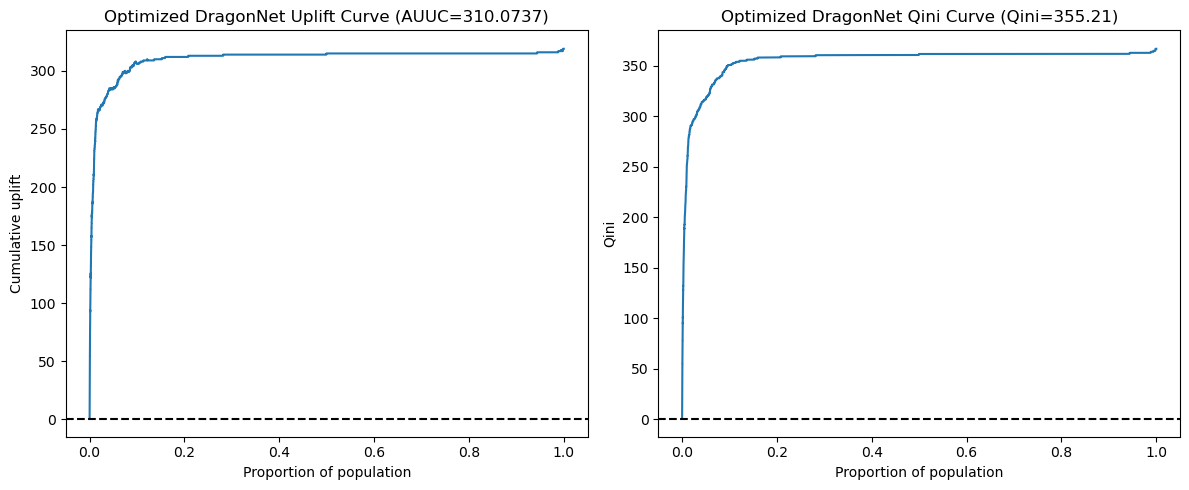

Training Easy T-Learner
 - Treated samples: 595000
 - Control samples: 105000
T-Learner Easy AUUC: 226.7115
T-Learner Easy Qini: 253.8606


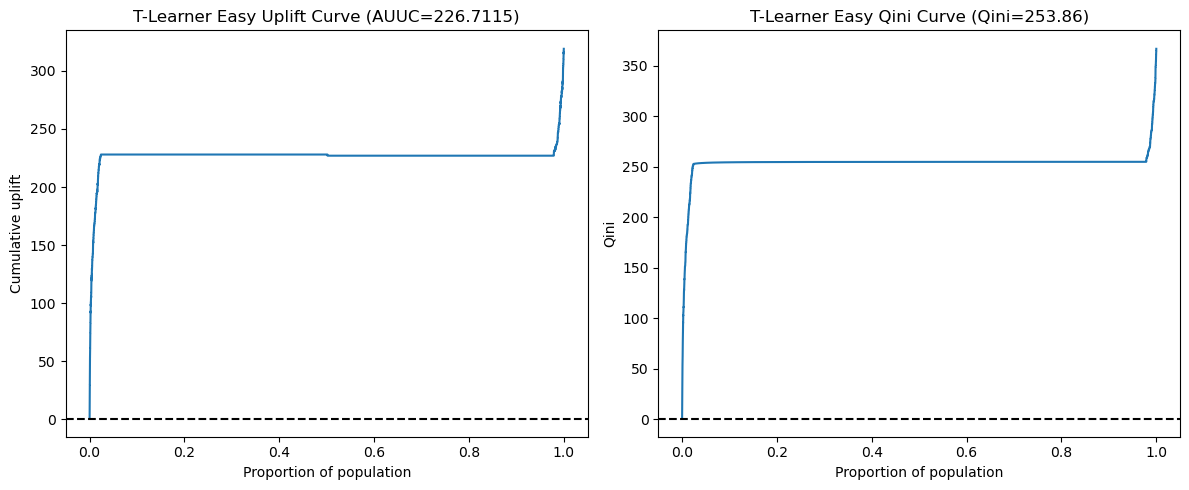


=========== FINAL NUMBERS ===========
Optimized DragonNet AUUC: 310.0737
T-Learner Easy AUUC:      226.7115
------------------------------------
Optimized DragonNet Qini: 355.2064
T-Learner Easy Qini:      253.8606
Total Uplift (DragonNet - Treated Group): 960.8959
Total Uplift (T-Learner - Treated Group): 58.367147459807136


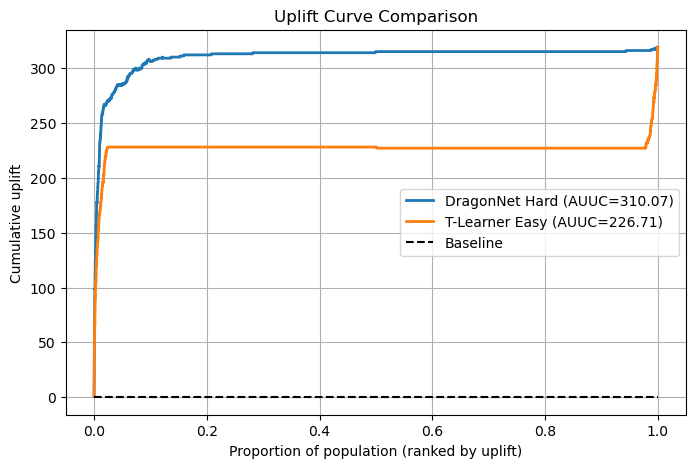

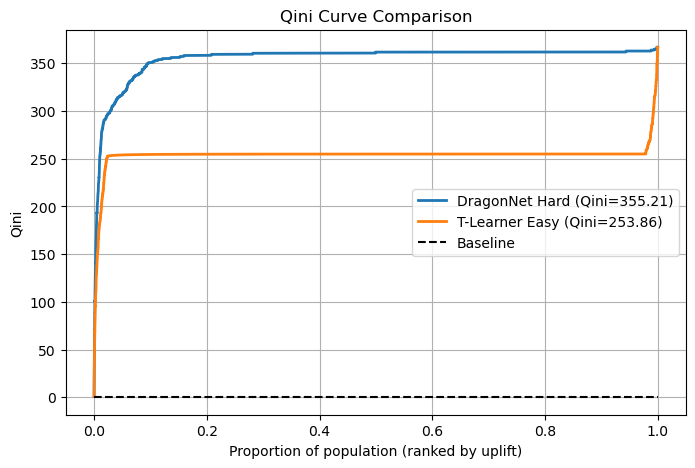

In [23]:
# ============================================================
# 9. RUN EVERYTHING
# ============================================================

# ---- Hard problem: Optimized DragonNet ----
dragonnet_model = train_dragonnet_optimized(
    X_train, y_train, t_train,
    X_val,   y_val,   t_val,
    lr=1e-3,
    batch_size=4096,
    epochs=15,
    tarreg_ratio=1.0,
    reg_l2=1e-4,
    dropout=0.15
)

auuc_hard, qini_hard, uplift_hard = evaluate_dragonnet(
    dragonnet_model, X_test, y_test, t_test, label="Optimized DragonNet"
)

# ---- Easy problem: Two-model T-learner ----
model_treated, model_control = train_two_model_tlearner(
    X_train, y_train, t_train
)

auuc_easy, qini_easy, uplift_easy = evaluate_two_model(
    model_treated, model_control, X_test, y_test, t_test,
    label="T-Learner Easy"
)

print("\n=========== FINAL NUMBERS ===========")
print(f"Optimized DragonNet AUUC: {auuc_hard:.4f}")
print(f"T-Learner Easy AUUC:      {auuc_easy:.4f}")
print("------------------------------------")
print(f"Optimized DragonNet Qini: {qini_hard:.4f}")
print(f"T-Learner Easy Qini:      {qini_easy:.4f}")
total_uplift_hard = uplift_hard[t_test == 1].sum()
print("Total Uplift (DragonNet - Treated Group):", total_uplift_hard)
total_uplift_easy = uplift_easy[t_test == 1].sum()
print("Total Uplift (T-Learner - Treated Group):", total_uplift_easy)


# ---- Direct curve comparison plots ----
plot_comparison_uplift(y_test, t_test, uplift_hard, uplift_easy)
plot_comparison_qini(y_test, t_test, uplift_hard, uplift_easy)
